# Denoising via Variational Autoencoder Model

We now evaluate the effectiveness of the variational autoencoder as a tool for both denoising
and feature extraction. 

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from preprocess import load_fixedSize, returnEventDistribution, preprocessInputs

### Analyze the data. Consider events ordered by the number of samples we have.
eventDistribution = returnEventDistribution('MU')
print(eventDistribution)

### Where X represents input EEG data, Y represents OHE MNIST labels, and Y_raw
# represents the raw MNIST labels.
feature_size = 476
X, Y, Y_raw = load_fixedSize(feature_size, 'MU')
X = preprocessInputs(X)
feature_size = X.shape[1]
print('Feature Size: ', feature_size)

Reading MU dataset...
OrderedDict([(476, 51272), (460, 44432), (459, 32815), (493, 18504), (442, 9584), (510, 3308), (425, 2208), (527, 728), (408, 312), (544, 224), (561, 52), (474, 40), (461, 32), (438, 16), (468, 16), (478, 16), (457, 12), (472, 12), (497, 12), (470, 12), (467, 12), (492, 12), (473, 12), (464, 12), (479, 12), (480, 12), (465, 12), (490, 12), (456, 12), (446, 8), (506, 8), (495, 8), (463, 8), (444, 8), (477, 8), (462, 8), (485, 8), (475, 8), (454, 8), (491, 8), (443, 8), (484, 8), (471, 8), (452, 4), (486, 4), (449, 4), (578, 4), (482, 4), (508, 4), (458, 4), (488, 4), (483, 4), (469, 4), (455, 4), (440, 4), (439, 4), (501, 4), (536, 4), (612, 4), (450, 4), (481, 4), (453, 4), (487, 4), (448, 4), (524, 4), (445, 4), (451, 4), (498, 4), (509, 4)])
Reading MU dataset...
Preprocessing complete.
Inputs shape: (51272, 476) || Labels shape: (51272, 10)
Feature Size:  476


Once again, we visualize the data before training our variational autoencoder model.

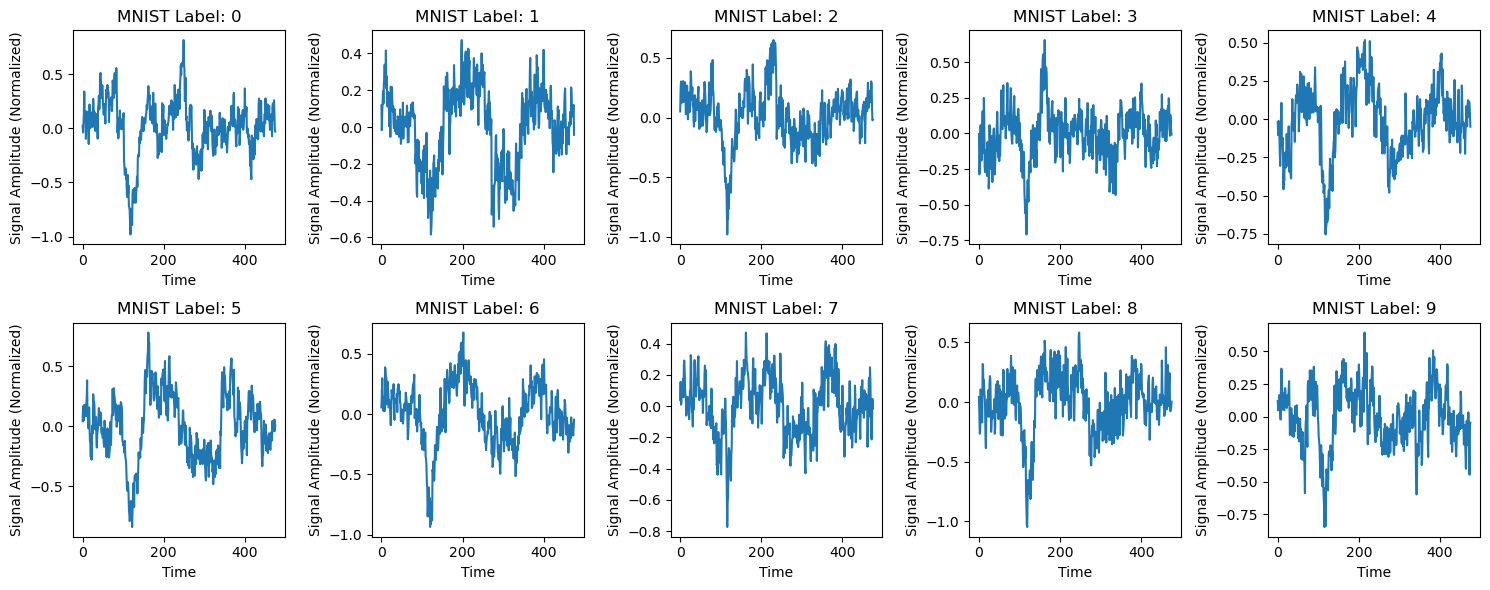

In [3]:
## Sanity Check on Data. 
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

averaged_samples = defaultdict(list)

for signal, label in zip(X, Y_raw):
    averaged_samples[label].append(signal)

# Calculate the average of each label. This is the average signal for each label.
for label, signals in averaged_samples.items():
    averaged_signal = np.mean(signals, axis=0)
    averaged_samples[label] = averaged_signal

# Plot the averaged signals
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    averaged_signal, label = averaged_samples[i], i
    axes[i].plot(averaged_signal)
    axes[i].set_title(f"MNIST Label: {label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal Amplitude (Normalized)")

plt.tight_layout()
plt.show()

Here our train-test split will look different since the labels are the data itself.
We consequently try to regenerate the images as best as we can, but this is also 
mainly focused on feature extraction.

In [4]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Split the data into train-validation-testing sets
X_train, X_val_test = train_test_split(X, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_val_test, test_size=0.5, random_state=42)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_val_tensor = torch.tensor(X_val)
X_test_tensor = torch.tensor(X_test)

# Create TensorDatasets for train-validation-testing sets
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

# Create Dataloaders for train-validation-testing sets
vae_train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vae_val_dataloader = DataLoader(val_dataset, batch_size=32)
vae_test_dataloader = DataLoader(test_dataset, batch_size=32)


We define our variational autoencoder model and train it to reconstruct data.

In [5]:
from models.autoencoder import VAE
from torch import optim, nn

### Model Setup
vae_model = VAE()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
vae_model.to(device)

criterion = nn.KLDivLoss()
optimizer = optim.Adam(vae_model.parameters(), lr=0.0001)

Running on cpu


In [ ]:
### Training Loop
num_epochs = 10
vae_epoch_train_losses = []
vae_epoch_val_losses   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    vae_model.train()
    for batchX in vae_train_dataloader:
        # Forward pass
        batchX = batchX[0].to(device)
        outputs = vae_model(batchX)
        outputs = outputs.squeeze(1)
        
        # Backward pass
        loss = criterion(outputs, batchX)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    vae_model.eval()
    with torch.no_grad():
        for batchX in vae_val_dataloader:
            batchX = batchX[0].to(device)
            outputs = vae_model(batchX)
            outputs = outputs.squeeze(1)

            loss = criterion(outputs, batchX)
            epoch_val_loss += loss.item()

    # Save and print losses
    epoch_train_loss /= len(vae_train_dataloader)
    epoch_val_loss   /= len(vae_val_dataloader)

    vae_epoch_train_losses.append(epoch_train_loss)
    vae_epoch_val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss}")

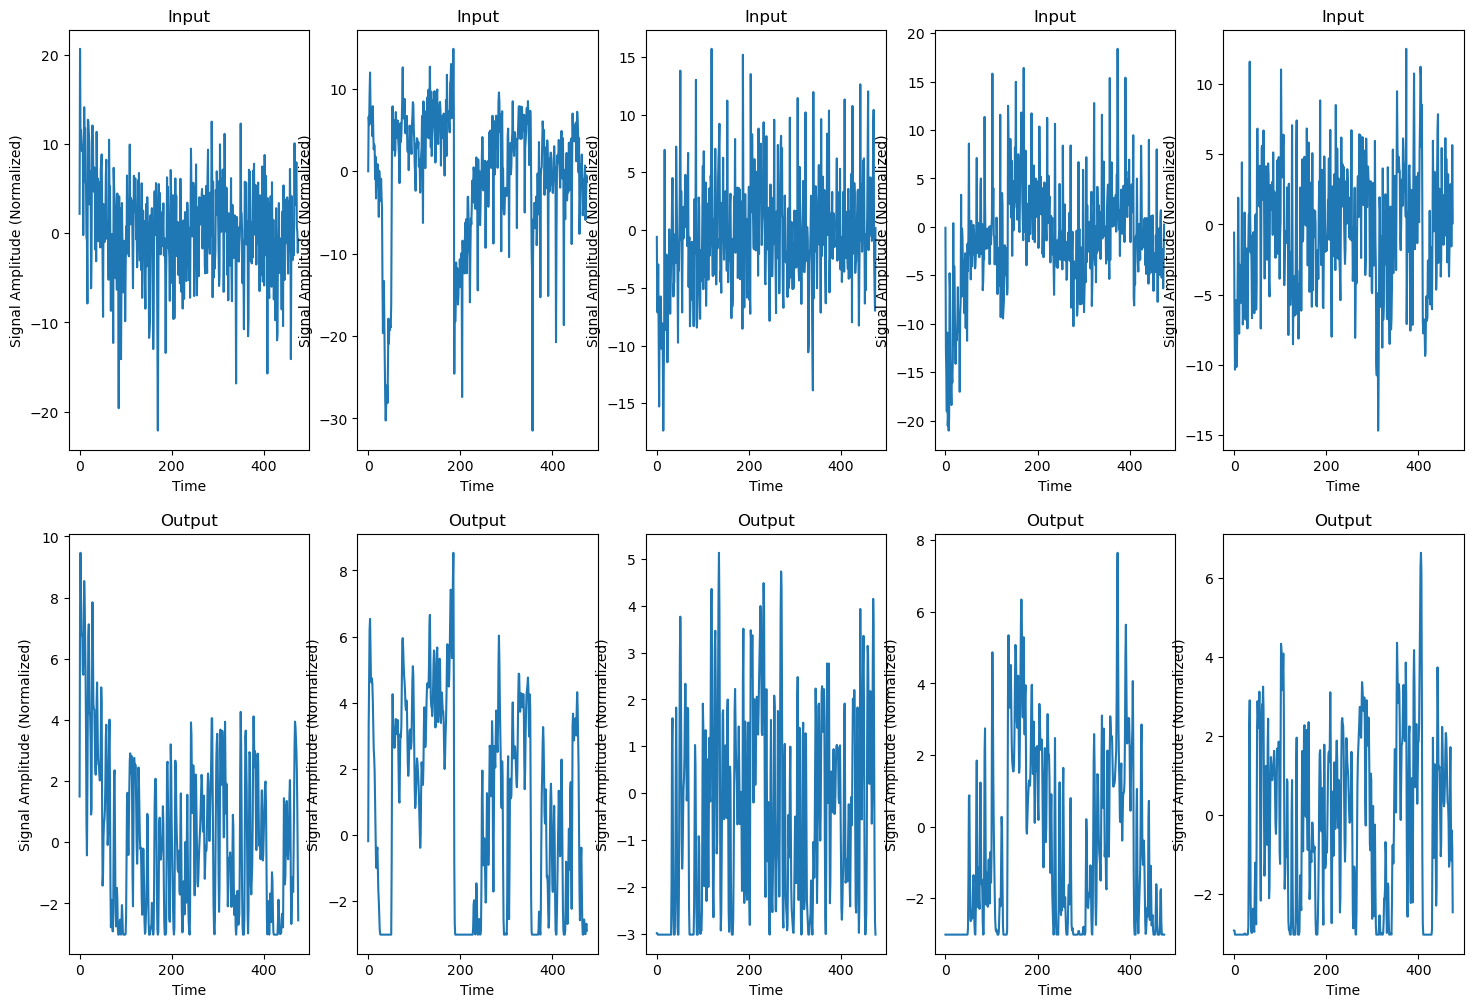

In [13]:
# Select a random sample from the test dataset
import matplotlib.pyplot as plt

# Set the autoencoder model to evaluation mode
vae_model.eval()

# Select a random sample from the test dataset
sample_indices = np.array([0, 1, 2, 3, 4])
num_samples = len(sample_indices)
fig, axes = plt.subplots(2, num_samples, figsize=(18, 12))

for i, sample_index in enumerate(sample_indices):
    # Select the sample
    sample_input = X_test_tensor[sample_index].unsqueeze(0).to(device)
    sample_output = vae_model(sample_input)

    # Convert the tensors to numpy arrays
    input_array = sample_input.cpu().detach().numpy()
    output_array = sample_output.cpu().detach().numpy()

    # Reshape the arrays to match the original shape
    input_array = input_array.reshape(-1, feature_size)
    output_array = output_array.reshape(-1, feature_size)

    # Plot the input and output side by side
    axes[0, i].plot(input_array[0])
    axes[0, i].set_title("Input")
    axes[0, i].set_xlabel("Time")
    axes[0, i].set_ylabel("Signal Amplitude (Normalized)")

    axes[1, i].plot(output_array[0])
    axes[1, i].set_title("Output")
    axes[1, i].set_xlabel("Time")
    axes[1, i].set_ylabel("Signal Amplitude (Normalized)")
plt.show()

### Baseline Re-Running

We now re-run our baselines and compare their performance to the original baselines
on the original data.

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train, validation, and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
Y_train, Y_val, Y_test = np.float32(Y_train), np.float32(Y_val), np.float32(Y_test)

# Convert the data to PyTorch tensors.
X_train_tensor, X_val_tensor, X_test_tensor = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
Y_train_tensor, Y_val_tensor, Y_test_tensor = torch.from_numpy(Y_train), torch.from_numpy(Y_val), torch.from_numpy(Y_test)

# Create TensorDatasets for train and test sets.
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoader for train and test sets.
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
from models.baseline import mlp_Baseline
from torch import optim, nn

### Model Setup
mlp_model = mlp_Baseline(feature_size, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

Running on cpu


In [16]:
### Training Loop
num_epochs = 10
mlp_epoch_train_losses = []
mlp_epoch_val_losses   = []
mlp_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    mlp_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        batchX = batchX.to(device)
        outputs = vae_model(batchX).to(device)
        outputs = mlp_model(outputs).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        
        # Backward pass
        loss = criterion(outputs, batchY.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    mlp_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            batchX = batchX.to(device)
            outputs = vae_model(batchX).to(device)
            outputs = mlp_model(outputs).to(device)
            outputs = torch.squeeze(outputs, dim=1)

            loss = criterion(outputs, batchY.to(device))
            epoch_val_loss += loss.item()

            pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
            for a, b in zip(pred, actual):
                if np.argmax(a) == np.argmax(b):
                    epoch_accuracy += 1 / len(batchX)

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    mlp_epoch_train_losses.append(epoch_train_loss)
    mlp_epoch_val_losses.append(epoch_val_loss)
    mlp_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.3126352784290205 || Validation loss: 2.3079322156221744 || Accuracy: 0.43127925117003835
Epoch 2 Training loss: 2.30458603386326 || Validation loss: 2.302404436975857 || Accuracy: 0.4164781591263572
Epoch 3 Training loss: 2.302947023233522 || Validation loss: 2.303213427665639 || Accuracy: 0.4164781591263572
Epoch 4 Training loss: 2.302961102327951 || Validation loss: 2.3024022281634826 || Accuracy: 0.4164781591263572
Epoch 5 Training loss: 2.302948889729881 || Validation loss: 2.3025030769907553 || Accuracy: 0.4164781591263572
Epoch 6 Training loss: 2.304707375219943 || Validation loss: 2.30289472116509 || Accuracy: 0.4164781591263572
Epoch 7 Training loss: 2.30327252063414 || Validation loss: 2.3025719723351847 || Accuracy: 0.4164781591263572
Epoch 8 Training loss: 2.302711424825096 || Validation loss: 2.3022650904290947 || Accuracy: 0.4164781591263572
Epoch 9 Training loss: 2.3024674981321076 || Validation loss: 2.302380101171187 || Accuracy: 0.4410491419656

The test accuracy is: 0.4387437613405601


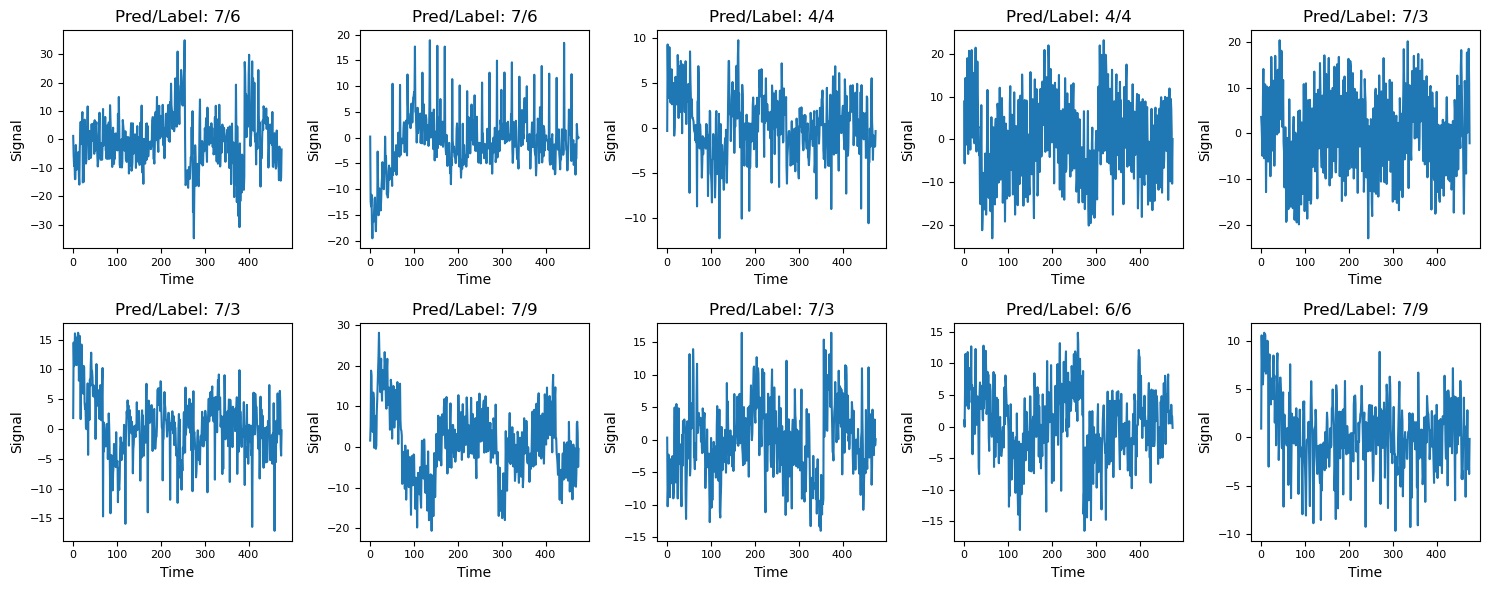

In [18]:
# Set the MLP model to evaluation mode
mlp_model.eval()

acc = 0
with torch.no_grad():
    for (batchX, batchY) in test_dataloader:
        outputs = vae_model(batchX.to(device)).to(device)
        outputs = mlp_model(outputs).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        loss = criterion(outputs, batchY.to(device))
        epoch_val_loss += loss.item()

        pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
        for a, b in zip(pred, actual):
            if np.argmax(a) == np.argmax(b):
                acc += 1
print(f"The test accuracy is: {acc / len(X_test_tensor)}")

# Define the indices to plot
indices = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + 30
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over the indices and plot the samples
for i, index in enumerate(indices):
    # Select the sample from the test dataset
    sample_input = X_test_tensor[index].unsqueeze(0).to(device)
    sample_label = Y_test_tensor[index]

    # Pass the sample through the MLP model
    sample_input = vae_model(sample_input).to(device)
    sample_output = mlp_model(sample_input).to(device)

    # Convert the tensors to numpy arrays
    input_array = sample_input.cpu().detach().numpy()
    output_array = sample_output.cpu().detach().numpy()

    # Reshape the arrays to match the original shape
    input_array = input_array.reshape(-1, feature_size)
    output_array = output_array.reshape(-1, 10)

    # Get the predicted and actual labels
    predicted_label = np.argmax(output_array)
    actual_label = np.argmax(sample_label)

    # Plot the input signal with predicted and actual labels
    axes[i].plot(input_array[0])
    axes[i].set_title(f"Pred/Label: {predicted_label}/{actual_label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal")
    axes[i].tick_params(axis='both', which='both', labelsize=8)
    
plt.tight_layout()
plt.show()

In [23]:
### Model Setup
from models.baseline import rnn_Baseline

rnn_model = rnn_Baseline(128, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

Running on cpu


In [21]:
### Training Loop
num_epochs = 10
rnn_epoch_train_losses = []
rnn_epoch_val_losses   = []
rnn_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    mlp_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        batchX = batchX.to(device)
        outputs = vae_model(batchX).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        outputs = rnn_model(outputs).to(device)
        
        # Backward pass
        loss = criterion(outputs, batchY.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    mlp_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            batchX = batchX.to(device)
            outputs = vae_model(batchX).to(device)
            outputs = torch.squeeze(outputs, dim=1)
            outputs = rnn_model(outputs).to(device)

            loss = criterion(outputs, batchY.to(device))
            epoch_val_loss += loss.item()

            pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
            for a, b in zip(pred, actual):
                if np.argmax(a) == np.argmax(b):
                    epoch_accuracy += 1 / len(batchX)

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    rnn_epoch_train_losses.append(epoch_train_loss)
    rnn_epoch_val_losses.append(epoch_val_loss)
    rnn_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.306012701 || Validation loss: 2.317351145 || Accuracy: 0.769871295
Epoch 2 Training loss: 2.264539734 || Validation loss: 2.228360373 || Accuracy: 0.787145742
Epoch 3 Training loss: 2.195888694 || Validation loss: 2.137611830 || Accuracy: 0.805170172
Epoch 4 Training loss: 2.115037152 || Validation loss: 2.120826190 || Accuracy: 0.817638679
Epoch 5 Training loss: 2.060466012 || Validation loss: 2.101198678 || Accuracy: 0.833744987
Epoch 6 Training loss: 2.035852173 || Validation loss: 2.061505489 || Accuracy: 0.845830795
Epoch 7 Training loss: 2.009805077 || Validation loss: 2.004938383 || Accuracy: 0.864992465
Epoch 8 Training loss: 1.969267755 || Validation loss: 1.906744558 || Accuracy: 0.875110420
Epoch 9 Training loss: 1.895261944 || Validation loss: 1.866523460 || Accuracy: 0.888113865
Epoch 10 Training loss: 1.801327717 || Validation loss: 1.814769872 || Accuracy: 0.904982868


The test accuracy is: 0.876859046219467


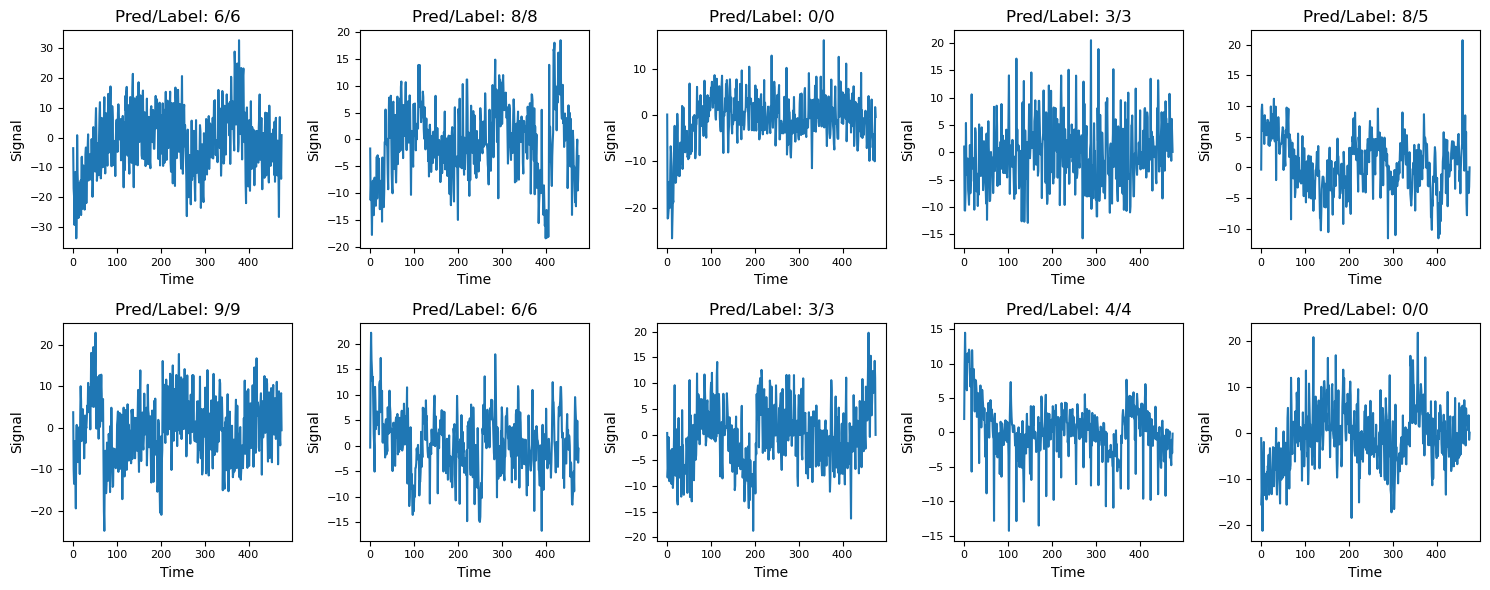

In [24]:
# Set the MLP model to evaluation mode
rnn_model.eval()

acc = 0
with torch.no_grad():
    for (batchX, batchY) in test_dataloader:
        outputs = vae_model(batchX.to(device)).to(device)
        outputs = torch.squeeze(outputs, dim=1)
        outputs = mlp_model(outputs).to(device)
        
        loss = criterion(outputs, batchY.to(device))
        epoch_val_loss += loss.item()

        pred, actual = outputs.detach().cpu().numpy(), batchY.detach().cpu().numpy()
        for a, b in zip(pred, actual):
            if np.argmax(a) == np.argmax(b):
                acc += 1
print(f"The test accuracy is: {acc / len(X_test_tensor)}")

# Define the indices to plot
indices = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over the indices and plot the samples
for i, index in enumerate(indices):
    # Select the sample from the test dataset
    sample_input = X_test_tensor[index].unsqueeze(0).to(device)
    sample_label = Y_test_tensor[index]

    # Pass the sample through the MLP model
    sample_input = vae_model(sample_input).to(device)
    sample_output = rnn_model(sample_input).to(device)

    # Convert the tensors to numpy arrays
    input_array = sample_input.cpu().detach().numpy()
    output_array = sample_output.cpu().detach().numpy()

    # Reshape the arrays to match the original shape
    input_array = input_array.reshape(-1, feature_size)
    output_array = output_array.reshape(-1, 10)

    # Get the predicted and actual labels
    predicted_label = np.argmax(output_array)
    actual_label = np.argmax(sample_label)

    # Plot the input signal with predicted and actual labels
    axes[i].plot(input_array[0])
    axes[i].set_title(f"Pred/Label: {predicted_label}/{actual_label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal")
    axes[i].tick_params(axis='both', which='both', labelsize=8)
    
plt.tight_layout()
plt.show()